In [1]:
import time 
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib
import seaborn as sns
import googlemaps
import folium

from bs4 import BeautifulSoup
from requests import get

sns.set()
%matplotlib inline

# Scraping data from https://www.immobilienscout24.de/

In [4]:
urls = []
streets = []
areas = []
prices = []
sqms = []
rooms = []
n_pages = 0

headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

#There are 161 pages of rental properties in Berlin
for page in range(1,161):
    n_pages += 1
    sapo_url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-mieten?pagenumber='+str(page)
    r = get(sapo_url, headers=headers)
    page_html = BeautifulSoup(r.text, 'html.parser')
    house_containers = page_html.find_all('div', class_="result-list-entry__data")
    if house_containers != []:
        for container in house_containers:
            
            #listing id
            idnum = container.find('button').get('data-id')
            if idnum == None:
                continue
            urls.append('https://www.immobilienscout24.de/expose/' + idnum)
            
            #street and area
            address = container.find_all('div')[1].text
            address = address.split(',')
            
            if len(address)>2:
                street = address[0]
                area = address[1]
            elif len(address)==2:
                street = ''
                area = address[0]
            else:
                continue
                
            street = street.replace('\n', '')
            area = area.replace(' ', '')
            streets.append(street)
            areas.append(area)
            
            # Price            
            price = container.find_all('div')[5].find_all('dd')[0].text
            price = price.replace(' €', '')
            price = price.replace('.', '')
            price = price.replace(',', '.')
            prices.append(float(price))
            
            #sqm
            sqm = container.find_all('div')[5].find_all('dd')[1].text
            sqm = sqm.replace(' m²', '')
            sqm = sqm.replace(',', '.')
            sqms.append(float(sqm))
            
            #rooms
            room = container.find_all('div')[5].find_all('dd')[2].text
            room = room.split(' ')[0]
            rooms.append(room)
    else:
        break
    
    time.sleep(random.randint(1,2))

print('You scraped {} pages containing {} properties.'.format(n_pages, len(areas)))

You scraped 160 pages containing 3189 properties.


In [5]:
results = pd.DataFrame({
    'Street': streets,
    'Area': areas,
    'Price': prices,
    'sqm': sqms,
    'Rooms': rooms,
    'Url' : urls
})

In [6]:
results['PricePerSqm'] = results.Price / results.sqm

# EDA

In [7]:
len(results.Area.value_counts())

85

In [8]:
#only 80 areas with more than 5 listings
(results.Area.value_counts()>5).sum()

66

In [9]:
areas = results.Area.value_counts().index[:66]

In [10]:
#get results only in the top 64 areas
results = results[results.Area.isin(areas)]

In [11]:
results.Area.value_counts()

Tiergarten(Tiergarten)                    357
Mitte(Mitte)                              251
Charlottenburg(Charlottenburg)            221
Friedrichshain(Friedrichshain)            161
Wedding(Wedding)                          143
Neukölln(Neukölln)                        134
PrenzlauerBerg(PrenzlauerBerg)            129
Wilmersdorf(Wilmersdorf)                  123
Kreuzberg(Kreuzberg)                      110
Köpenick(Köpenick)                        109
Spandau(Spandau)                          102
Schöneberg(Schöneberg)                     74
Hellersdorf(Hellersdorf)                   69
Lichterfelde(Steglitz)                     56
Reinickendorf(Reinickendorf)               56
Pankow(Pankow)                             55
Lichtenberg(Lichtenberg)                   51
Oberschöneweide(Köpenick)                  51
Friedrichsfelde(Lichtenberg)               47
Weißensee(Weißensee)                       43
Alt-Hohenschönhausen(Hohenschönhausen)     41
Steglitz(Steglitz)                

In [12]:
len(results)

3151

In [13]:
results.head(30)

,Street,Area,Price,sqm,Rooms,Url,PricePerSqm
0,Stallschreiberstraße 27,Mitte(Mitte),1799.00,95.80,4,https://www.immobilienscout24.de/expose/115478066,18.778706
1,Schöneberger Ufer 5,Kreuzberg(Kreuzberg),887.68,24.82,1,https://www.immobilienscout24.de/expose/115238928,35.764706
2,Fraunhoferstraße 22,Charlottenburg(Charlottenburg),2355.86,168.24,5,https://www.immobilienscout24.de/expose/110356560,14.002972
4,Bismarckstraße 80,Charlottenburg(Charlottenburg),2225.70,148.38,3,https://www.immobilienscout24.de/expose/111917240,15.000000
5,Huttenstraße 72,Tiergarten(Tiergarten),1541.00,119.47,4,https://www.immobilienscout24.de/expose/113144431,12.898636
6,Zeppelinstr. 85,Spandau(Spandau),497.17,60.52,2,https://www.immobilienscout24.de/expose/115168796,8.214970
7,Groener Straße 19,Spandau(Spandau),1016.00,112.67,4,https://www.immobilienscout24.de/expose/115461269,9.017485
8,Weverstr. 7,Spandau(Spandau),532.19,65.46,2,https://www.immobilienscout24.de/expose/115439152,8.130003
9,Am Hohen Feld 125a,Karow(Weißensee),1158.95,89.15,3,https://www.immobilienscout24.de/expose/114618260,13.000000
10,Am Hohen Feld 125a,Karow(Weißensee),799.32,66.61,2,https://www.immobilienscout24.de/expose/109894326,12.000000


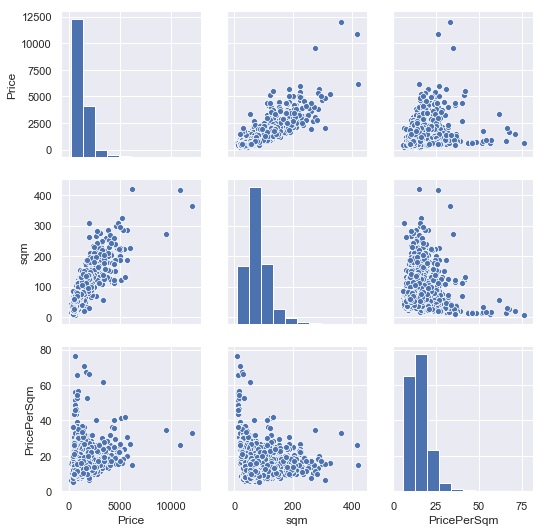

In [14]:
sns.pairplot(results)

In [15]:
mean_per_area = results.groupby('Area').mean()


# Mean price per square meter sorted alphabetically

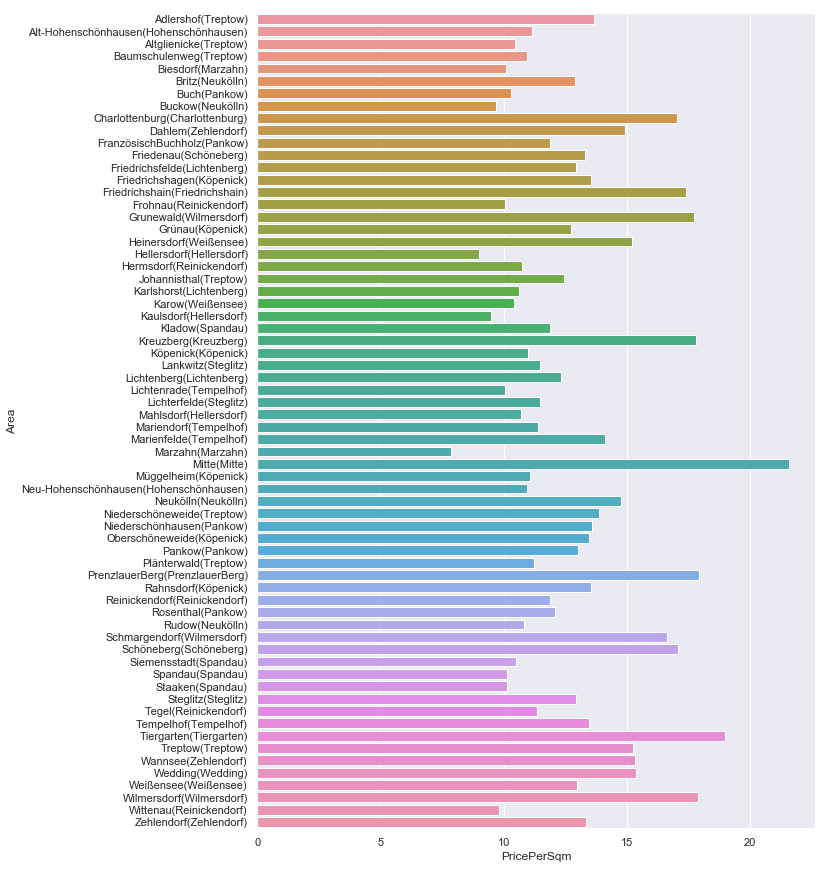

In [16]:
fig = plt.figure(figsize=(10,15))
sns.barplot(mean_per_area.PricePerSqm, mean_per_area.index)

# Mean price per square meter sorted by value

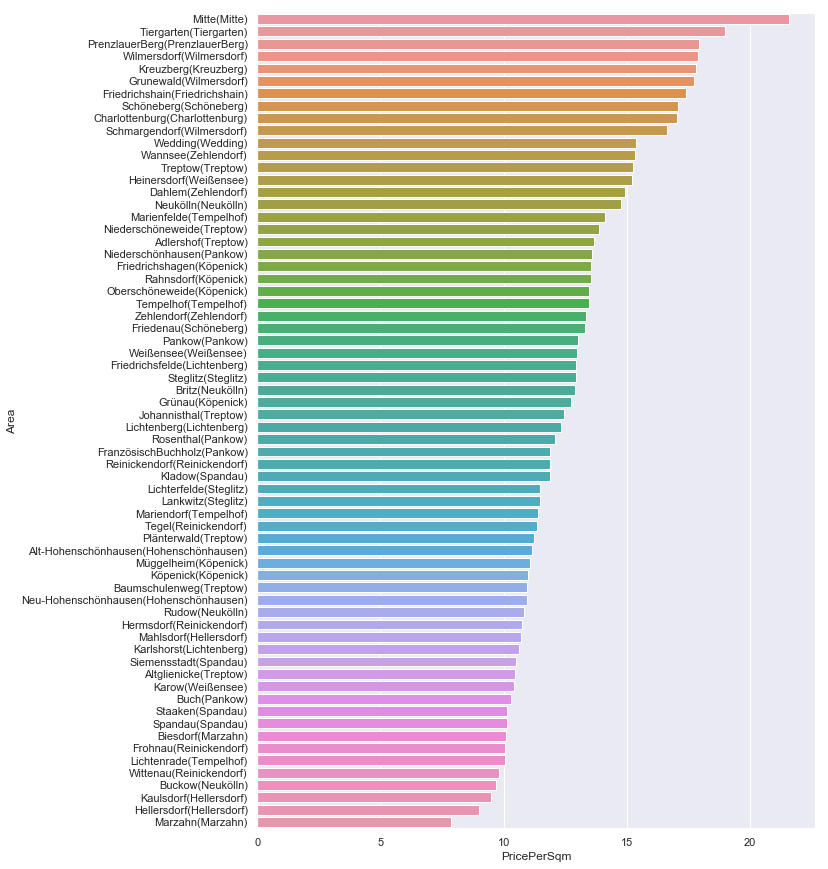

In [17]:
mean_per_area.sort_values(by='PricePerSqm', ascending=False, inplace=True)
fig = plt.figure(figsize=(10,15))
sns.barplot(mean_per_area.PricePerSqm, mean_per_area.index)

# Getting coordinates with Google maps

In [18]:
gmaps = googlemaps.Client(key='your-api-key-here')

In [19]:
lat = []
lng = []
for index, row in results.iterrows():
    if row.Street != '':
        geocode_result = gmaps.geocode(row.Street + ', Berlin')
    else:
        geocode_result = gmaps.geocode(row.Area + ', Berlin')
    lat.append(geocode_result[0]['geometry']['location']['lat'])
    lng.append(geocode_result[0]['geometry']['location']['lng'])
    
    if index%300 == 0:
        print('Got {} coordinates!'.format(index))

Got 0 coordinates!
Got 300 coordinates!
Got 600 coordinates!
Got 900 coordinates!
Got 1200 coordinates!
Got 1500 coordinates!
Got 1800 coordinates!
Got 2100 coordinates!
Got 2400 coordinates!
Got 2700 coordinates!
Got 3000 coordinates!


In [20]:
results['lat'] = lat
results['lng'] = lng

In [21]:
results.head(15)

,Street,Area,Price,sqm,Rooms,Url,PricePerSqm,lat,lng
0,Stallschreiberstraße 27,Mitte(Mitte),1799.00,95.80,4,https://www.immobilienscout24.de/expose/115478066,18.778706,52.508521,13.406499
1,Schöneberger Ufer 5,Kreuzberg(Kreuzberg),887.68,24.82,1,https://www.immobilienscout24.de/expose/115238928,35.764706,52.502697,13.373920
2,Fraunhoferstraße 22,Charlottenburg(Charlottenburg),2355.86,168.24,5,https://www.immobilienscout24.de/expose/110356560,14.002972,52.515787,13.318043
4,Bismarckstraße 80,Charlottenburg(Charlottenburg),2225.70,148.38,3,https://www.immobilienscout24.de/expose/111917240,15.000000,52.511208,13.304678
5,Huttenstraße 72,Tiergarten(Tiergarten),1541.00,119.47,4,https://www.immobilienscout24.de/expose/113144431,12.898636,52.527298,13.328142
6,Zeppelinstr. 85,Spandau(Spandau),497.17,60.52,2,https://www.immobilienscout24.de/expose/115168796,8.214970,52.546338,13.184756
7,Groener Straße 19,Spandau(Spandau),1016.00,112.67,4,https://www.immobilienscout24.de/expose/115461269,9.017485,52.543221,13.203022
8,Weverstr. 7,Spandau(Spandau),532.19,65.46,2,https://www.immobilienscout24.de/expose/115439152,8.130003,52.519660,13.201092
9,Am Hohen Feld 125a,Karow(Weißensee),1158.95,89.15,3,https://www.immobilienscout24.de/expose/114618260,13.000000,52.613974,13.496126
10,Am Hohen Feld 125a,Karow(Weißensee),799.32,66.61,2,https://www.immobilienscout24.de/expose/109894326,12.000000,52.613974,13.496126


In [22]:
#save to csv
results.to_csv('housing_data.csv', index=False)

# Plotting results with Folium

In [45]:
m = folium.Map(
    location=[52.524103, 13.379575],
    zoom_start=12
)

cmap = matplotlib.cm.get_cmap('bwr')
norm = matplotlib.colors.Normalize(vmin=7, vmax=23)

for index, row in results.iterrows():
    
    html="""
        <a href={url} target="_blank">Click here for the original listing</a>
        <ul>
          <li>{street}</li>
          <li>Price: {price} &euro;</li>
          <li>Sqm: {sqm} &#13217;</li>
          <li>Rooms: {rooms}</li>
          <li>Price/sqm: {psqm:.2f} &euro;</li>
          <li>Mean price/sqm in {area}: {mean:.2f} &euro;</li>
          <li>Difference: {delta:.2f} &euro;</li>
        </ul>
        
        """.format(
                street = row.Street, 
                price = row.Price, 
                sqm = row.sqm, 
                rooms = row.Rooms, 
                psqm = row.PricePerSqm,
                url = row.Url,
                area = row.Area,
                mean = mean_per_area[mean_per_area.index == row.Area].PricePerSqm.values[0],
                delta = row.PricePerSqm - mean_per_area[mean_per_area.index == row.Area].PricePerSqm.values[0]
            )
    iframe = folium.IFrame(html=html, width=250, height=220)
    popup = folium.Popup(iframe, max_width=300)

    
    folium.Circle(
        location=[row.lat, row.lng],
        radius=110,
        popup=popup,
        color=col.to_hex(cmap(norm(row.PricePerSqm))),
        fill=True,
        fill_opacity = 0.5
    ).add_to(m)
    
m.save('housing.html')